# Prediction Demo - Flowers Recognition
## Introduction
This notebook demonstrates **practical usage** of our trained flower recognition model. We will create a simple demo system that can classify new flower images and show prediction results with confidence scores.

**Dataset:** Flowers Recognition (Kaggle)

**Objective:** Explore and visualize the dataset to gain insights and guide further analysis

**Author:** NGUYEN Ngoc Dang Nguyen - Final-year Student in Computer Science, Aix-Marseille University

**Demo features:**
1. Load the best trained model
2. Create image preprocessing functions
3. Make single image predictions
4. Visualize prediction results
5. Test with sample images
6. Simple web interface

## 1. Setup and Model Loading

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import cv2

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
plt.style.use('default')
sns.set_palette("husl")

# Paths
MODELS_PATH = r"C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models"
PROCESSED_PATH = r"C:\Users\nndng\OneDrive\Desktop\flowers-recognition\data\processed"
DEMO_PATH = r"C:\Users\nndng\OneDrive\Desktop\flowers-recognition\demo"

# Create demo directory
os.makedirs(DEMO_PATH, exist_ok=True)

print("Flower Recognition Prediction Demo")
print("=" * 40)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# 1.1 Load Best Model
def load_best_model():
    """Load the best trained model and class names"""
    
    # Try to find the best model file
    model_files = []
    for file in os.listdir(MODELS_PATH):
        if file.endswith('_best.h5'):
            model_files.append(file)
    
    if not model_files:
        raise FileNotFoundError("No trained model found! Please run training first.")
    
    # Load the first available model (you can modify this logic)
    model_file = model_files[0]
    model_path = os.path.join(MODELS_PATH, model_file)
    
    print(f"Loading model: {model_file}")
    model = keras.models.load_model(model_path)
    
    # Load class names from test data
    test_path = os.path.join(PROCESSED_PATH, 'test')
    if os.path.exists(test_path):
        class_names = sorted(os.listdir(test_path))
        class_names = [name for name in class_names if os.path.isdir(os.path.join(test_path, name))]
    else:
        # Fallback class names (update these based on your dataset)
        class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    
    print(f"Model loaded successfully!")
    print(f"Parameters: {model.count_params():,}")
    print(f"Classes ({len(class_names)}): {class_names}")
    
    return model, class_names

# Load model and class names
model, class_names = load_best_model()

Flower Recognition Prediction Demo
TensorFlow version: 2.20.0
GPU available: False
Loading model: Improved_CNN_best.h5


Model loaded successfully!
Parameters: 161,733
Classes (5): ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


## 2. Image Preprocessing

In [12]:
class SimpleImagePreprocessor:
    """Simple image preprocessing for flower recognition"""
    
    def __init__(self, img_size=(224, 224)):
        self.img_size = img_size
    
    def preprocess_image(self, image_path):
        """Load and preprocess a single image"""
        try:
            # Load image
            image = Image.open(image_path)
            
            # Convert to RGB if needed
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Resize image
            image = image.resize(self.img_size, Image.Resampling.LANCZOS)
            
            # Convert to numpy array and normalize
            image_array = np.array(image)
            image_array = image_array.astype(np.float32) / 255.0
            
            return image_array, image
        
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None, None
    
    def preprocess_pil_image(self, pil_image):
        """Preprocess a PIL Image object"""
        try:
            # Convert to RGB if needed
            if pil_image.mode != 'RGB':
                pil_image = pil_image.convert('RGB')
            
            # Resize image
            pil_image = pil_image.resize(self.img_size, Image.Resampling.LANCZOS)
            
            # Convert to numpy array and normalize
            image_array = np.array(pil_image)
            image_array = image_array.astype(np.float32) / 255.0
            
            return image_array, pil_image
        
        except Exception as e:
            print(f"Error processing PIL image: {e}")
            return None, None

# Initialize preprocessor
preprocessor = SimpleImagePreprocessor()
print("Image preprocessor ready!")

Image preprocessor ready!


## 3. Prediction System

In [13]:
class FlowerPredictor:
    """Simple flower prediction system"""
    
    def __init__(self, model, class_names, preprocessor):
        self.model = model
        self.class_names = class_names
        self.preprocessor = preprocessor
        self.predictions_made = 0
    
    def predict_image(self, image_path, top_k=3):
        """Predict flower class for a single image"""
        
        # Preprocess image
        image_array, original_image = self.preprocessor.preprocess_image(image_path)
        
        if image_array is None:
            return None
        
        # Add batch dimension and predict
        image_batch = np.expand_dims(image_array, axis=0)
        predictions = self.model.predict(image_batch, verbose=0)[0]
        
        # Get top-k predictions
        top_indices = np.argsort(predictions)[-top_k:][::-1]
        
        results = []
        for idx in top_indices:
            results.append({
                'class': self.class_names[idx],
                'confidence': float(predictions[idx]),
                'percentage': float(predictions[idx] * 100)
            })
        
        self.predictions_made += 1
        
        return {
            'image_path': image_path,
            'predicted_class': results[0]['class'],
            'confidence': results[0]['confidence'],
            'top_predictions': results,
            'original_image': original_image
        }
    
    def predict_pil_image(self, pil_image, top_k=3):
        """Predict flower class for a PIL Image"""
        
        # Preprocess image
        image_array, processed_image = self.preprocessor.preprocess_pil_image(pil_image)
        
        if image_array is None:
            return None
        
        # Add batch dimension and predict
        image_batch = np.expand_dims(image_array, axis=0)
        predictions = self.model.predict(image_batch, verbose=0)[0]
        
        # Get top-k predictions
        top_indices = np.argsort(predictions)[-top_k:][::-1]
        
        results = []
        for idx in top_indices:
            results.append({
                'class': self.class_names[idx],
                'confidence': float(predictions[idx]),
                'percentage': float(predictions[idx] * 100)
            })
        
        self.predictions_made += 1
        
        return {
            'predicted_class': results[0]['class'],
            'confidence': results[0]['confidence'],
            'top_predictions': results,
            'original_image': processed_image
        }

# Initialize predictor
predictor = FlowerPredictor(model, class_names, preprocessor)
print("Flower predictor ready!")

Flower predictor ready!


## 4. Visualization Functions

In [14]:
def visualize_prediction(result, figsize=(12, 6)):
    """Visualize a single prediction result"""
    
    if result is None:
        print("No result to visualize")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Show original image
    ax1.imshow(result['original_image'])
    ax1.set_title(f"Input Image\nPredicted: {result['predicted_class']}\nConfidence: {result['confidence']:.3f}")
    ax1.axis('off')
    
    # Show prediction confidence
    classes = [pred['class'] for pred in result['top_predictions']]
    percentages = [pred['percentage'] for pred in result['top_predictions']]
    
    colors = ['green', 'orange', 'red'][:len(classes)]
    bars = ax2.barh(classes, percentages, color=colors, alpha=0.7)
    
    # Add percentage labels
    for bar, pct in zip(bars, percentages):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}%', ha='left', va='center')
    
    ax2.set_xlabel('Confidence (%)')
    ax2.set_title('Top Predictions')
    ax2.set_xlim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_predictions(results, max_display=6):
    """Visualize multiple prediction results"""
    
    if not results:
        print("No results to visualize")
        return
    
    n_results = min(len(results), max_display)
    cols = 3
    rows = (n_results + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(rows * cols):
        row, col = i // cols, i % cols
        
        if i < n_results:
            result = results[i]
            axes[row, col].imshow(result['original_image'])
            
            title = f"{result['predicted_class']}\n{result['confidence']:.3f}"
            color = 'green' if result['confidence'] >= 0.7 else 'orange'
            axes[row, col].set_title(title, color=color)
        
        axes[row, col].axis('off')
    
    plt.suptitle(f'Predictions (Showing {n_results} images)', fontsize=16)
    plt.tight_layout()
    plt.show()

## 5. Demo with Sample Images

Looking for sample images...
Found 10 sample images

Testing predictions on sample images:

Image 1: 10140303196_b88d3d6cec.jpg
True class: daisy
Predicted: dandelion
Confidence: 0.987
Correct: No
Top 3 predictions:
  1. dandelion: 98.7%
  2. rose: 0.8%
  3. tulip: 0.2%

Image 2: 10466558316_a7198b87e2.jpg
True class: daisy
Predicted: dandelion
Confidence: 0.404
Correct: No
Top 3 predictions:
  1. dandelion: 40.4%
  2. tulip: 33.5%
  3. daisy: 9.2%

Image 3: 10294487385_92a0676c7d_m.jpg
True class: dandelion
Predicted: dandelion
Confidence: 0.896
Correct: Yes
Top 3 predictions:
  1. dandelion: 89.6%
  2. sunflower: 7.1%
  3. tulip: 1.2%

Image 4: 10443973_aeb97513fc_m.jpg
True class: dandelion
Predicted: dandelion
Confidence: 0.981
Correct: Yes
Top 3 predictions:
  1. dandelion: 98.1%
  2. rose: 1.0%
  3. sunflower: 0.8%

Image 5: 102501987_3cdb8e5394_n.jpg
True class: rose
Predicted: dandelion
Confidence: 0.859
Correct: No
Top 3 predictions:
  1. dandelion: 85.9%
  2. tulip: 5.2%
  3.

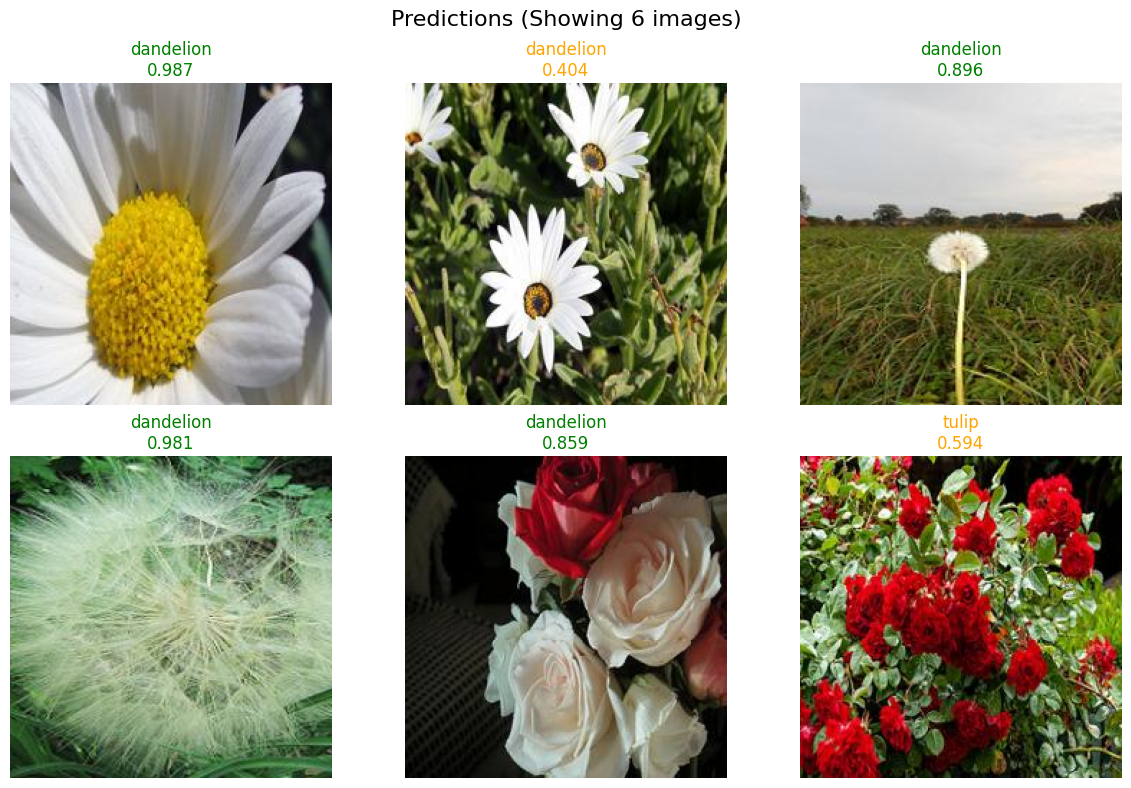


Detailed view 1:


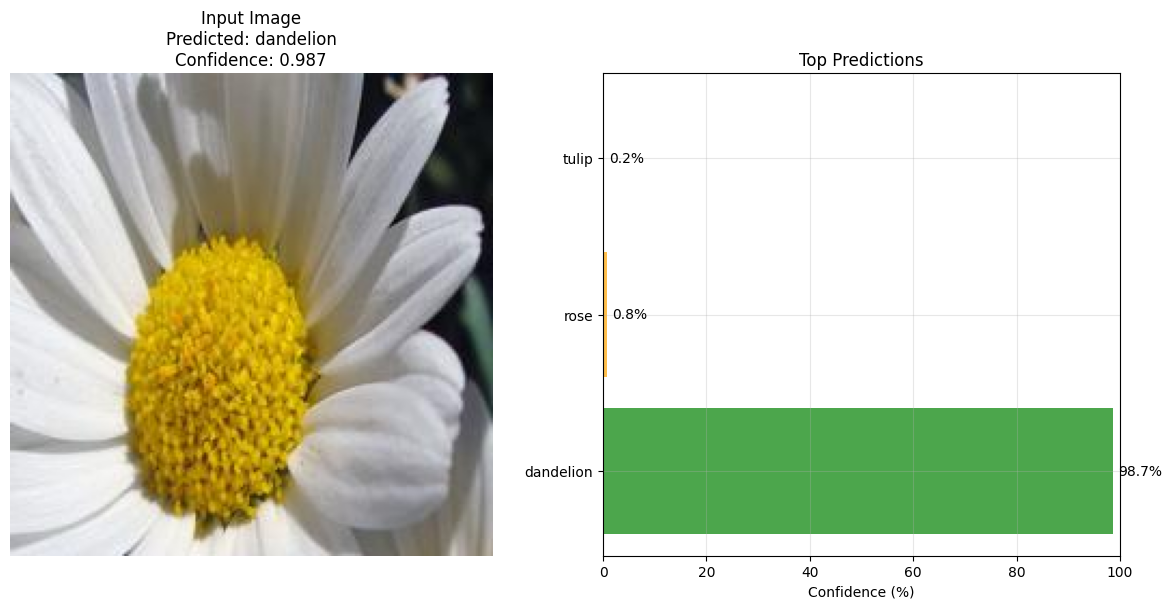


Detailed view 2:


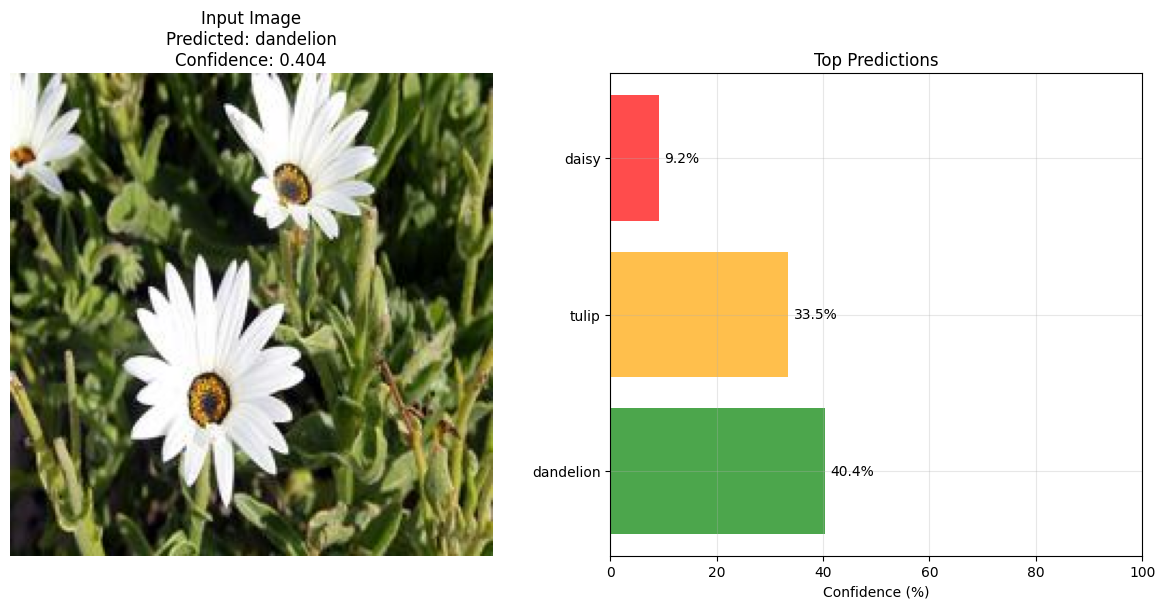


Detailed view 3:


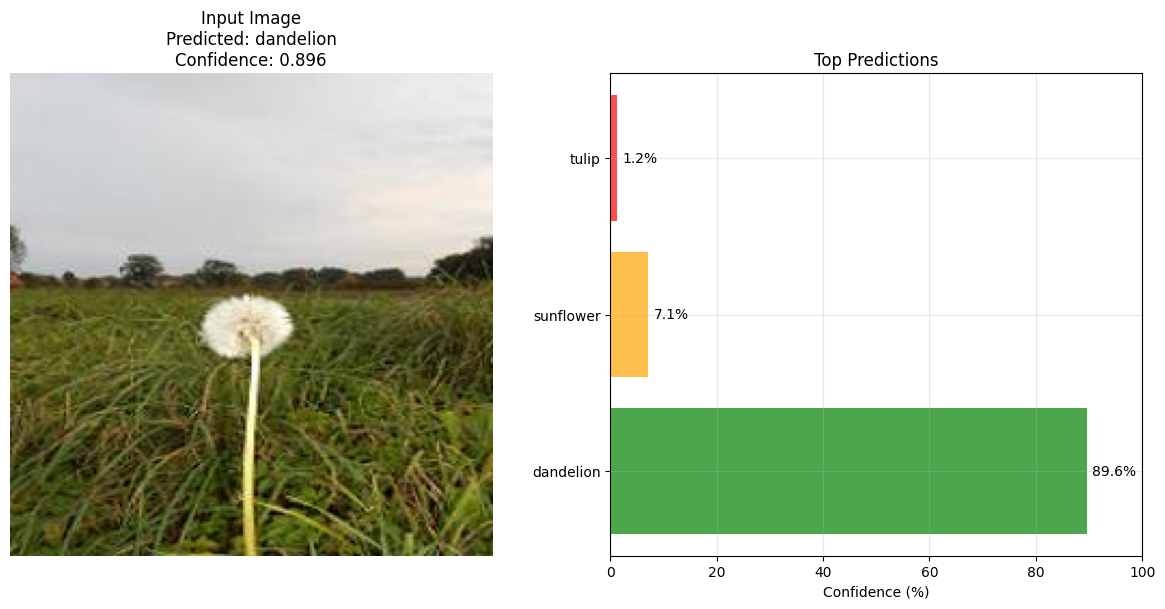

In [15]:
def find_sample_images(data_path, max_per_class=2):
    """Find sample images for demonstration"""
    sample_images = []
    
    # Look in test directory
    test_path = os.path.join(data_path, 'test')
    if not os.path.exists(test_path):
        print(f"Test directory not found: {test_path}")
        return sample_images
    
    for class_name in class_names:
        class_path = os.path.join(test_path, class_name)
        if os.path.exists(class_path):
            # Find image files
            image_files = []
            for file in os.listdir(class_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    image_files.append(os.path.join(class_path, file))
            
            # Take a few samples
            for img_path in image_files[:max_per_class]:
                sample_images.append({
                    'path': img_path,
                    'true_class': class_name,
                    'filename': os.path.basename(img_path)
                })
    
    return sample_images

# Find sample images
print("Looking for sample images...")
sample_images = find_sample_images(PROCESSED_PATH)

if sample_images:
    print(f"Found {len(sample_images)} sample images")
    
    # Test a few predictions
    print("\nTesting predictions on sample images:")
    test_results = []
    
    for i, sample in enumerate(sample_images[:6]):  # Test first 6
        print(f"\nImage {i+1}: {sample['filename']}")
        print(f"True class: {sample['true_class']}")
        
        result = predictor.predict_image(sample['path'])
        if result:
            test_results.append(result)
            print(f"Predicted: {result['predicted_class']}")
            print(f"Confidence: {result['confidence']:.3f}")
            print(f"Correct: {'Yes' if result['predicted_class'] == sample['true_class'] else 'No'}")
            
            # Show top 3 predictions
            print("Top 3 predictions:")
            for j, pred in enumerate(result['top_predictions']):
                print(f"  {j+1}. {pred['class']}: {pred['percentage']:.1f}%")
    
    # Visualize results
    if test_results:
        print(f"\nVisualizing {len(test_results)} predictions...")
        visualize_multiple_predictions(test_results)
        
        # Show individual detailed results
        for i, result in enumerate(test_results[:3]):  # Show first 3 detailed
            print(f"\nDetailed view {i+1}:")
            visualize_prediction(result)

else:
    print("No sample images found.")
    print("Make sure you have run the preprocessing notebook and have test images.")

## 6. Interactive Testing

In [16]:
def interactive_prediction():
    """Interactive prediction function"""
    
    print("\nInteractive Flower Prediction")
    print("=" * 35)
    
    if not sample_images:
        print("No sample images available for testing.")
        return
    
    while True:
        print(f"\nOptions:")
        print("1. Test random sample image")
        print("2. Test specific image by index")
        print("3. Show all sample images")
        print("4. Show prediction statistics")
        print("5. Exit")
        
        choice = input("\nEnter your choice (1-5): ").strip()
        
        if choice == '1':
            # Random prediction
            import random
            sample = random.choice(sample_images)
            
            print(f"\nTesting: {sample['filename']}")
            print(f"True class: {sample['true_class']}")
            
            result = predictor.predict_image(sample['path'])
            if result:
                print(f"Predicted: {result['predicted_class']}")
                print(f"Confidence: {result['confidence']:.3f}")
                print(f"Correct: {'Yes' if result['predicted_class'] == sample['true_class'] else 'No'}")
                
                visualize_prediction(result)
        
        elif choice == '2':
            # Specific image
            print(f"\nAvailable images (0-{len(sample_images)-1}):")
            for i, sample in enumerate(sample_images[:10]):  # Show first 10
                print(f"  {i}: {sample['filename']} ({sample['true_class']})")
            
            try:
                idx = int(input(f"\nEnter index (0-{min(9, len(sample_images)-1)}): "))
                if 0 <= idx < len(sample_images):
                    sample = sample_images[idx]
                    
                    print(f"\nTesting: {sample['filename']}")
                    result = predictor.predict_image(sample['path'])
                    if result:
                        visualize_prediction(result)
                else:
                    print("Invalid index!")
            except ValueError:
                print("Please enter a valid number!")
        
        elif choice == '3':
            # Show all samples
            print(f"\nAll {len(sample_images)} sample images:")
            for i, sample in enumerate(sample_images):
                print(f"  {i}: {sample['filename']} ({sample['true_class']})")
        
        elif choice == '4':
            # Statistics
            if predictor.predictions_made > 0:
                print(f"\nPrediction Statistics:")
                print(f"Total predictions made: {predictor.predictions_made}")
            else:
                print("No predictions made yet.")
        
        elif choice == '5':
            print("Goodbye!")
            break
        
        else:
            print("Invalid choice! Please enter 1-5.")

# You can run the interactive demo with: interactive_prediction()
print("Run interactive_prediction() to start the interactive demo!")

Run interactive_prediction() to start the interactive demo!


## 7. Simple Web Interface

In [17]:
def create_simple_web_interface():
    """Create a simple web interface using Gradio (if available)"""
    
    try:
        import gradio as gr
    except ImportError:
        print("Gradio not installed. Install with: pip install gradio")
        return None
    
    def predict_uploaded_image(image):
        """Function for Gradio interface"""
        if image is None:
            return "Please upload an image", ""
        
        try:
            result = predictor.predict_pil_image(image)
            if result:
                prediction_text = f"Predicted Class: {result['predicted_class']}\n"
                prediction_text += f"Confidence: {result['confidence']:.3f} ({result['confidence']*100:.1f}%)\n"
                
                details_text = "Top 3 Predictions:\n"
                for i, pred in enumerate(result['top_predictions']):
                    details_text += f"{i+1}. {pred['class']}: {pred['percentage']:.1f}%\n"
                
                return prediction_text, details_text
            else:
                return "Error processing image", ""
        
        except Exception as e:
            return f"Error: {str(e)}", ""
    
    # Create interface
    interface = gr.Interface(
        fn=predict_uploaded_image,
        inputs=gr.Image(type="pil", label="Upload a flower image"),
        outputs=[
            gr.Textbox(label="Prediction Result"),
            gr.Textbox(label="Details")
        ],
        title="Flower Recognition Demo",
        description=f"Upload an image of a flower to identify its type. Supported types: {', '.join(class_names)}"
    )
    
    return interface

# Create web interface
web_interface = create_simple_web_interface()

if web_interface:
    print("Web interface created!")
    print("To launch it, run: web_interface.launch()")
else:
    print("Gradio not available - web interface not created")

Web interface created!
To launch it, run: web_interface.launch()


## 8. Batch Prediction

In [18]:
def predict_batch_images(image_paths, show_results=True):
    """Predict multiple images at once"""
    
    print(f"Processing {len(image_paths)} images...")
    results = []
    correct_predictions = 0
    
    for i, img_path in enumerate(image_paths):
        print(f"Processing {i+1}/{len(image_paths)}: {os.path.basename(img_path)}")
        
        result = predictor.predict_image(img_path)
        if result:
            results.append(result)
            
            # Check accuracy if we know the true class
            true_class = None
            for sample in sample_images:
                if sample['path'] == img_path:
                    true_class = sample['true_class']
                    break
            
            if true_class and result['predicted_class'] == true_class:
                correct_predictions += 1
    
    # Show results
    if results:
        print(f"\nBatch Processing Complete!")
        print(f"Successful predictions: {len(results)}/{len(image_paths)}")
        
        if correct_predictions > 0:
            accuracy = correct_predictions / len(results) * 100
            print(f"Accuracy: {accuracy:.1f}%")
        
        # Show confidence statistics
        confidences = [r['confidence'] for r in results]
        print(f"Average confidence: {np.mean(confidences):.3f}")
        print(f"Min confidence: {np.min(confidences):.3f}")
        print(f"Max confidence: {np.max(confidences):.3f}")
        
        if show_results:
            visualize_multiple_predictions(results)
        
        return results
    else:
        print("No successful predictions!")
        return []

# Test batch prediction
if sample_images:
    print("You can test batch prediction with:")
    print("batch_results = predict_batch_images([sample['path'] for sample in sample_images[:6]])")

You can test batch prediction with:
batch_results = predict_batch_images([sample['path'] for sample in sample_images[:6]])


## 9. Model Performance Summary

In [19]:
def show_demo_summary():
    """Show summary of demo session"""
    
    print("FLOWER RECOGNITION DEMO SUMMARY")
    print("=" * 40)
    
    print(f"Model Information:")
    print(f"  Parameters: {model.count_params():,}")
    print(f"  Classes: {len(class_names)}")
    print(f"  Class names: {class_names}")
    
    print(f"\nDemo Statistics:")
    print(f"  Sample images found: {len(sample_images)}")
    print(f"  Predictions made: {predictor.predictions_made}")
    
    if sample_images:
        print(f"\nAvailable for testing:")
        class_counts = {}
        for sample in sample_images:
            cls = sample['true_class']
            class_counts[cls] = class_counts.get(cls, 0) + 1
        
        for cls, count in class_counts.items():
            print(f"  {cls}: {count} images")
    
    print(f"\nNext steps:")
    print("  1. Run interactive_prediction() for manual testing")
    print("  2. Use predict_batch_images() for batch testing")
    print("  3. Launch web_interface.launch() if Gradio is available")
    print("  4. Use predictor.predict_image(path) for custom images")

# Show summary
show_demo_summary()

FLOWER RECOGNITION DEMO SUMMARY
Model Information:
  Parameters: 161,733
  Classes: 5
  Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Demo Statistics:
  Sample images found: 10
  Predictions made: 6

Available for testing:
  daisy: 2 images
  dandelion: 2 images
  rose: 2 images
  sunflower: 2 images
  tulip: 2 images

Next steps:
  1. Run interactive_prediction() for manual testing
  2. Use predict_batch_images() for batch testing
  3. Launch web_interface.launch() if Gradio is available
  4. Use predictor.predict_image(path) for custom images


## 10. Usage Examples

USAGE EXAMPLES

1. Predict a single image:
result = predictor.predict_image('path/to/your/image.jpg')
visualize_prediction(result)

2. Interactive demo:
interactive_prediction()

3. Batch prediction:
paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
results = predict_batch_images(paths)

4. Web interface (if Gradio installed):
web_interface.launch()

5. Predict PIL Image:
from PIL import Image
img = Image.open('your_image.jpg')
result = predictor.predict_pil_image(img)

6. Test with available samples:
# Random test
Sample test - True: sunflower, Predicted: dandelion, Confidence: 0.990


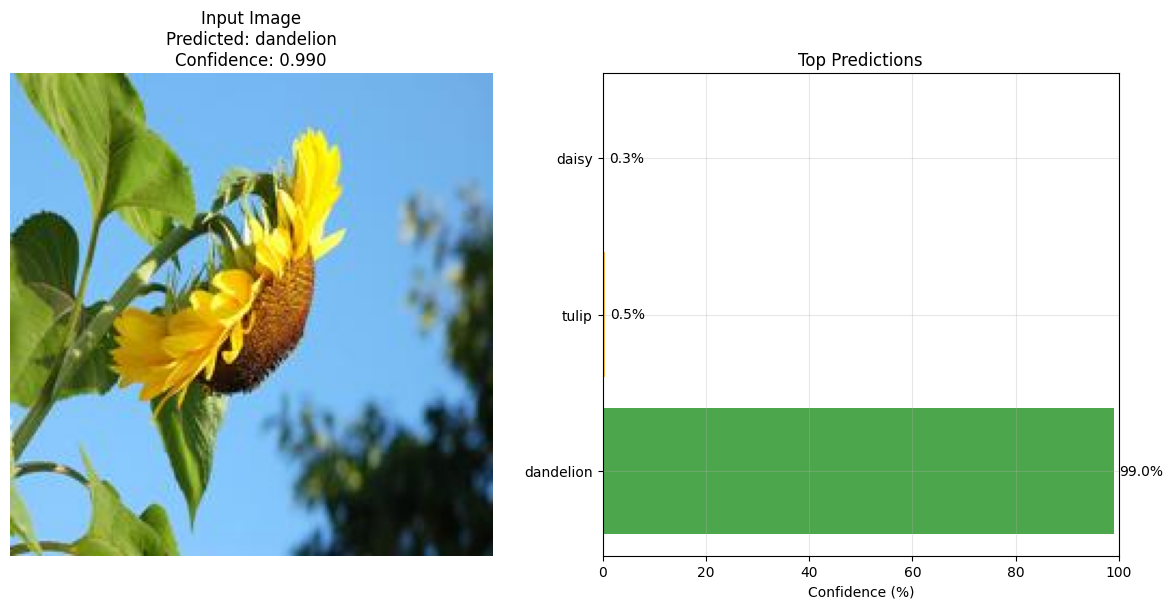


Demo ready! Try the examples above to test your model.


In [20]:
print("USAGE EXAMPLES")
print("=" * 20)

print("\n1. Predict a single image:")
print("result = predictor.predict_image('path/to/your/image.jpg')")
print("visualize_prediction(result)")

print("\n2. Interactive demo:")
print("interactive_prediction()")

print("\n3. Batch prediction:")
print("paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']")
print("results = predict_batch_images(paths)")

print("\n4. Web interface (if Gradio installed):")
print("web_interface.launch()")

print("\n5. Predict PIL Image:")
print("from PIL import Image")
print("img = Image.open('your_image.jpg')")
print("result = predictor.predict_pil_image(img)")

if sample_images:
    print(f"\n6. Test with available samples:")
    print("# Random test")
    import random
    sample = random.choice(sample_images)
    result = predictor.predict_image(sample['path'])
    if result:
        print(f"Sample test - True: {sample['true_class']}, Predicted: {result['predicted_class']}, Confidence: {result['confidence']:.3f}")
        
        # Quick visualization
        visualize_prediction(result)

print("\nDemo ready! Try the examples above to test your model.")

## Conclusion
In this notebook, we built a complete demo system for flower recognition, including preprocessing, prediction, and visualization functions. The demo supports single and batch predictions, interactive testing, and a simple web interface. These features make it easy to evaluate the model on new data and prepare for deployment in real-world applications.
